In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy gspread oauth2client df2gspread pandas matplotlib seaborn

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import pandas as pd 
import gspread
import seaborn
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import textwrap
import numpy as np
from itertools import chain
from oauth2client.service_account import ServiceAccountCredentials

In [3]:
pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_columns', 3000)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 0

In [28]:
run = 2

rawdata = {}
rawdata["Questions"] = []
rawdata["Answers"] = []
rawdata["Percentage"] = []

if run == 1:
    for i in range(1,8):
        for j in range(1,6):
            rawdata["Questions"].append(f"Q{i}")
            rawdata["Answers"].append(j)
    rawdata["Percentage"].extend([2.040816327,14.28571429,53.06122449,28.57142857,2.040816327])
    rawdata["Percentage"].extend([4.081632653,8.163265306,38.7755102,36.73469388,12.24489796])
    rawdata["Percentage"].extend([0,14.28571429,32.65306122,34.69387755,18.36734694])
    rawdata["Percentage"].extend([2.040816327,8.163265306,28.57142857,44.89795918,16.32653061])
    rawdata["Percentage"].extend([4.081632653,2.040816327,28.57142857,38.7755102,26.53061224])
    rawdata["Percentage"].extend([2.040816327,6.12244898,38.7755102,36.73469388,16.32653061])
    rawdata["Percentage"].extend([2.040816327,8.163265306,28.57142857,26.53061224,34.69387755])
elif run == 2:
    for i in range(1,9):
        for j in range(1,6):
            rawdata["Questions"].append(f"Q{i}")
            rawdata["Answers"].append(j)
    rawdata["Percentage"].extend([2.752293578,21.10091743,23.85321101,34.86238532,17.43119266]) #Q3
    rawdata["Percentage"].extend([1.834862385,13.76146789,22.93577982,35.77981651,25.68807339]) #Q4
    rawdata["Percentage"].extend([7.339449541,22.93577982,18.34862385,35.77981651,15.59633028]) #Q2
    rawdata["Percentage"].extend([0          ,5.504587156,19.26605505,40.36697248,34.86238532]) #Q5
    rawdata["Percentage"].extend([3.669724771,12.8440367 ,19.26605505,34.86238532,29.35779817]) #Q6
    rawdata["Percentage"].extend([7.339449541,22.01834862,20.18348624,26.60550459,23.85321101]) #Q7
    rawdata["Percentage"].extend([2.752293578,7.339449541,20.18348624,36.69724771,33.02752294]) #Q8
    rawdata["Percentage"].extend([3.669724771,21.10091743,37.6146789 ,29.35779817,8.256880734]) #Q1
else:
    raise Exception("Unknown run")

data = pd.DataFrame(rawdata)

In [29]:
new_percentages = []

for i, row in data.iterrows():
    new_percentages.append(data[(data["Questions"]==row["Questions"])&(data["Answers"]<=row["Answers"])]['Percentage'].sum())

data['Percentage'] = new_percentages

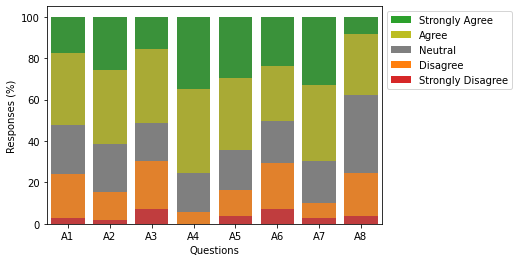

In [30]:
if len(data[data['Answers'] < 6]) > 0:
    ax1 = seaborn.barplot(x="Questions", y="Percentage", data=data[data['Answers']==5], color="C2",ci=None)
if len(data[data['Answers'] < 5]) > 0:
    ax2 = seaborn.barplot(x="Questions", y="Percentage", data=data[data['Answers']==4], color="C8",ci=None)
if len(data[data['Answers'] < 4]) > 0:
    ax3 = seaborn.barplot(x="Questions", y="Percentage", data=data[data['Answers']==3], color="C7",ci=None)
if len(data[data['Answers'] < 3]) > 0:
    ax4 = seaborn.barplot(x="Questions", y="Percentage", data=data[data['Answers']==2], color="C1",ci=None)
if len(data[data['Answers'] < 2]) > 0:
    ax5 = seaborn.barplot(x="Questions", y="Percentage", data=data[data['Answers']==1], color="C3",ci=None)
    
seaborn.barplot(x="Questions", y="Percentage", data=data[data['Answers'] < 6], alpha=0,ci=None)

ax5.set(xlabel='Questions', ylabel='Responses (%)', xticklabels=["A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8"])
strg_agree = mpatches.Patch(facecolor='C2', label='Strongly Agree')
agree = mpatches.Patch(facecolor='C8', label='Agree')
neutral = mpatches.Patch(facecolor='C7', label='Neutral')
disagree = mpatches.Patch(facecolor='C1', label='Disagree')
strg_disagree = mpatches.Patch(facecolor='C3', label='Strongly Disagree')
plt.legend(handles=[strg_agree,agree,neutral,disagree,strg_disagree], bbox_to_anchor=(1, 1))